## Configure Defaults

In [30]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [31]:
! pip install tensorflow==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Dependencies

In [32]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/EE599_project/sensor_data_new.csv', header=None)
df = df.sample(frac=1)

# df = df.apply(pd.to_numeric)
feature_col_ids = list(range(0,36))

x_values = df[feature_col_ids].astype(int, errors='ignore')

y_values = df[36].astype(int, errors='ignore')
SAMPLES = df.shape[0]



In [35]:
df[[36]].value_counts()

36
0     1737
1      999
2      572
dtype: int64

### 3. Split the Data

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 



In [36]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])



## Training

### 1. Design the Model


In [37]:

y_test

1082    0
3148    2
1892    1
2815    2
1279    0
       ..
2192    1
2412    1
1451    0
1390    0
1024    0
Name: 36, Length: 661, dtype: int64

In [38]:
y_values

979     0
595     0
1852    1
3234    2
1103    0
       ..
2763    2
905     0
1096    0
235     0
1061    0
Name: 36, Length: 3308, dtype: int64

In [39]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
979,1,1,-1,0,-1,-91,1,0,0,0,...,0,1,0,-89,-102,-103,-104,-104,-104,-193
595,-33,-28,-32,-30,-31,-121,-20,-15,-19,-17,...,-21,-19,-20,-110,-108,-102,-108,-106,-107,-198
1852,-1,0,-1,-1,-1,-57,-1,0,-1,-1,...,-18,-18,-18,-75,-15,-14,-16,-15,-15,-71
3234,-1,1,0,0,0,-3,-1,0,0,-1,...,-1,0,0,-2,-9,-8,-8,-7,-7,-9
1103,1,1,-1,0,-1,-92,1,0,-1,1,...,0,1,-1,-92,-102,-103,-106,-105,-106,-197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,-38,-33,-37,-35,-35,-127,-24,-18,-24,-22,...,-25,-23,-23,-116,-109,-103,-109,-106,-107,-199
590,-33,-28,-32,-30,-31,-121,-20,-15,-19,-17,...,-20,-19,-20,-110,-109,-103,-109,-106,-107,-197
2320,0,-1,0,0,1,-56,0,1,0,1,...,2,1,1,-55,-95,-95,-95,-94,-94,-149
1576,-19,-13,-17,-15,-15,-129,-12,-6,-10,-8,...,-11,-10,-10,-124,-133,-127,-131,-129,-129,-242


In [40]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
1082,0,0,-2,-1,-2,-95,1,0,-1,0,...,-1,0,-1,-93,-103,-104,-106,-105,-106,-199
3148,-1,0,0,0,0,18,-1,0,0,1,...,0,0,1,18,-11,-10,-8,-8,-8,8
1892,-2,0,-2,-2,-2,-58,-1,0,-1,-1,...,-18,-18,-18,-74,-15,-14,-16,-16,-15,-72
2815,-1,1,0,0,0,-6,-1,1,0,0,...,0,0,0,-6,-23,-21,-22,-23,-22,-27
1279,-16,-11,-13,-13,-13,-121,-9,-5,-7,-7,...,-9,-9,-8,-118,-127,-123,-125,-125,-125,-234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,0,0,0,1,0,-5,0,0,0,0,...,1,1,1,-4,-9,-9,-10,-9,-7,-13
2412,0,1,1,0,-1,-6,1,1,0,0,...,1,0,0,-4,21,20,20,19,20,16
1451,-16,-11,-14,-13,-13,-18,-10,-6,-9,-8,...,-11,-10,-9,-15,-117,-112,-115,-114,-114,-119
1390,-16,-11,-14,-13,-13,-19,-11,-6,-9,-7,...,-11,-10,-9,-16,-118,-112,-115,-114,-115,-120


In [41]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()
model_1.add(keras.layers.Dense(16, activation='relu', input_shape=(36,)))
# model_1.add(keras.layers.Dense(10, activation='relu'))
# model_1.add(keras.layers.Dense(8, activation='relu'))
# model_1.add(keras.layers.Dense(6, activation='relu'))
model_1.add(keras.layers.Dense(3, activation='relu'))

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                592       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 643
Trainable params: 643
Non-trainable params: 0
_________________________________________________________________
None


### 2. Train the Model


In [42]:
y_validate.value_counts()

0    364
1    191
2    108
Name: 36, dtype: int64

In [43]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=30, batch_size=16,
                        validation_data=(x_validate, y_validate))
model_1.save(MODEL_TF)

Epoch 1/30
124/124 [==============================] - 1s 4ms/step - loss: 3.9957 - accuracy: 0.5652 - val_loss: 3.4556 - val_accuracy: 0.6018
Epoch 2/30
124/124 [==============================] - 0s 2ms/step - loss: 3.3566 - accuracy: 0.6138 - val_loss: 2.8038 - val_accuracy: 0.6063
Epoch 3/30
124/124 [==============================] - 0s 2ms/step - loss: 2.8523 - accuracy: 0.6094 - val_loss: 2.8032 - val_accuracy: 0.6033
Epoch 4/30
124/124 [==============================] - 0s 4ms/step - loss: 2.9059 - accuracy: 0.6215 - val_loss: 2.7990 - val_accuracy: 0.6078
Epoch 5/30
124/124 [==============================] - 0s 2ms/step - loss: 2.8995 - accuracy: 0.6221 - val_loss: 2.7999 - val_accuracy: 0.6094
Epoch 6/30
124/124 [==============================] - 0s 2ms/step - loss: 3.0855 - accuracy: 0.6108 - val_loss: 2.8097 - val_accuracy: 0.6214
Epoch 7/30
124/124 [==============================] - 0s 2ms/step - loss: 2.9397 - accuracy: 0.6701 - val_loss: 2.6934 - val_accuracy: 0.7285
Epoch 

In [44]:
history_1.history

{'loss': [3.730778932571411,
  3.135476589202881,
  2.837120294570923,
  2.8198304176330566,
  2.818143606185913,
  2.833752393722534,
  2.7913570404052734,
  2.7361953258514404,
  2.736067056655884,
  2.7359671592712402,
  2.7359161376953125,
  2.735891819000244,
  2.735886812210083,
  2.73588490486145,
  2.735886335372925,
  2.7358851432800293,
  2.7358853816986084,
  2.7358858585357666,
  2.7358853816986084,
  2.73588490486145,
  2.735884666442871,
  2.7358856201171875,
  2.7358860969543457,
  2.7358858585357666,
  2.7358858585357666,
  2.7358858585357666,
  2.7358860969543457,
  2.7358858585357666,
  2.7358858585357666,
  2.7358856201171875],
 'accuracy': [0.6013104915618896,
  0.6159273982048035,
  0.6174395084381104,
  0.617943525314331,
  0.6209677457809448,
  0.6234878897666931,
  0.6935483813285828,
  0.7197580933570862,
  0.7227822542190552,
  0.7222782373428345,
  0.7242943644523621,
  0.7253023982048035,
  0.7247983813285828,
  0.7247983813285828,
  0.7247983813285828,
  0.

### 3. Plot Metrics

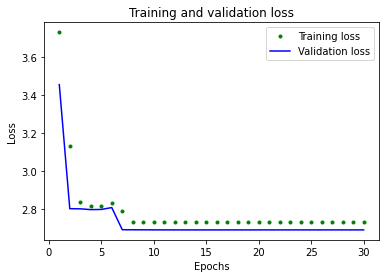

In [45]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

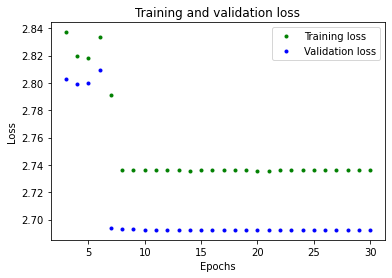

In [46]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 2

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

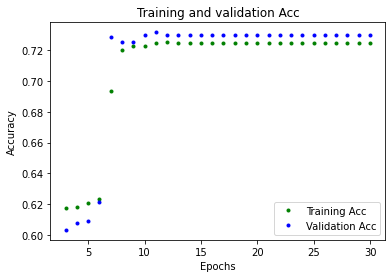

In [47]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

plt.plot(epochs[SKIP:], train_acc[SKIP:], 'g.', label='Training Acc')
plt.plot(epochs[SKIP:], val_acc[SKIP:], 'b.', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
y_test.value_counts()

0    319
1    216
2    126
Name: 36, dtype: int64

In [49]:
from tensorflow.keras.models import load_model

In [50]:
m = load_model(MODEL_TF)
model_1 = m

In [51]:
# Calculate and print the loss on our test dataset
test_loss, test_acc = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = np.argmax(model_1.predict(x_test), axis=1)

# # Graph the predictions against the actual values
# plt.clf()
# plt.title('Comparison of predictions and actual values')
# plt.plot(x_test, y_test, 'b.', label='Actual values')
# # plt.plot(x_test, y_test, 'b.')
# plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
# plt.legend()
# plt.show()

21/21 [==============================] - 0s 2ms/step - loss: 2.9784 - accuracy: 0.6853


In [52]:
pd.DataFrame(y_test_pred).value_counts()

0    492
1    145
2     24
dtype: int64

In [53]:
pd.DataFrame(y_test).value_counts()

36
0     319
1     216
2     126
dtype: int64

In [54]:
test_acc

0.6853252649307251

### 1. Generate Models without Quantization


In [55]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# # Convert the model to the TensorFlow Lite format with quantization
# def representative_dataset():
#   for i in range(500):
# #    yield([x_train[i].values.reshape(35, 1)])
#     yield(x_train[i])
# # Set the optimization flag.
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # Enforce integer only quantization
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# # Provide a representative dataset to ensure we quantize correctly.
# converter.representative_dataset = representative_dataset
# model_tflite = converter.convert()

# # Save the model to disk
# open(MODEL_TFLITE, "wb").write(model_tflite)

3784

In [56]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
# size_tflite = os.path.getsize(MODEL_TFLITE)
print(size_tf)
print(size_no_quant_tflite)

4096
3784


**Summary**

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [57]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 4s (62.7 kB/s)
Reading package li

## Deploy to a Microcontroller


In [58]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char models_model_no_quant_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x2c, 0x01, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x88, 0x02, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x34, 0x01, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x74, 0x0e, 0x00, 0x00,
  0x70, 0x0e, 0x00, 0x00, 0xa0, 0x0d, 0x00, 0x00, 0x10, 0x0d, 0x00, 0x00,
  0xc8, 0x03, 0x00, 0x00, 0xc0, 0x02, 0x00, 0x00, 0x5c, 0x0e, 0x00, 0x00,
  0x58, 0x0e, 0x00, 0x00, 0xcc, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x10, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0x2c, 0x00, 0